<a href="https://colab.research.google.com/github/sugampath/BERT-result/blob/master/Bertcleandata92%25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
pip install transformers

In [63]:
import pandas as pd
import numpy as np
import re
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset
from transformers import AdamW, get_linear_schedule_with_warmup
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import seaborn as sns

In [64]:
data=pd.read_csv("/content/drive/MyDrive/Thesis/dataset.csv")

In [65]:
data.rename(columns = {"label":"category"}, inplace = True)

In [66]:
data.head(10)

,feature,category
0,सुदूरपश्चिम समाज कतारको दोस्रो साधारणसभा सम्पन...,diaspora
1,अमेरिकाबाट गायिका थापाको देशभक्ति गीत (भिडियो ...,diaspora
2,आदिवासी जनजाति मञ्च अष्ट्रेलियामा नयाँ कार्यसम...,diaspora
3,नेपाल फेस्टिवल मेलवर्नः नेपालका पर्यटनमन्त्री ...,diaspora
4,नेपाल फेष्टिबलको धन्यवाद ज्ञापन सम्पन्न\n\n१२ ...,diaspora
5,आगलागी पीडित थापालाई भेटे एनआरएन अध्यक्षले\n\n...,diaspora
6,फिजीका नेपालीलाई नेपाली भाषा पढाइने\nभीमसेन सा...,diaspora
7,अष्ट्रेलियामा नेपालीको पहिलो संस्थाले पायो नया...,diaspora
8,कराते खेलाडी ठकुरी ‘अमेरिका गट ट्यालेन्ट’मा जा...,diaspora
9,ईयूका लागि नेपाली राजदूत नियुक्त भएपछि थापाले ...,diaspora


In [67]:
data["feature"][200]

'साउदी अरबको जेद्दामा मनाइयो ल्होछार\nजेद्दा । आफ्नो मौलिक धर्म, संस्कृति र परम्परालाई जगेर्ना गर्दै निरन्तर उत्थान, सम्बर्द्धन एवं प्रबर्द्धन गर्न साउदी अरबको जेद्धा आसपासमा रहेका तामाङ श्रमिकहरूले बृहत रूपमा सोनाम ल्होछार मनाएका छन् । ज्या ल्हो अर्थात चरा बर्गको नयाँ वर्ष २८५३ को आगमनलाई हर्षोउल्लासका साथ मनाइयो ।\nनेपाल तामाङ घेदुङ प्रवास शाखा साउदी अरबका अध्यक्ष विगेन्द्रसिंह वाइवाको सभापतित्वमा सम्पन्न उक्त कार्यक्रमलाई घेदुङका महासचिव नवराज घिसिङले संचालन गरेका थिए ।\nमहावाणीज्य दूतावासका कार्यवाहक महावाणीज्यदूत रेवती रमण पौडेलको प्रमुख आतिथ्यता भएको कार्यक्रममा अन्य अतिथिहरू वाणीज्यदूत मनहरी दंगाल, श्रम सहचारी भोजराज घिमिरे, आदिबासी जनजाति महासंघ साउदी अरबका केन्द्रिय उपाध्यक्ष बालकुमार राई, आदिबासी जनजाति महासंघ क्षेत्रीय समन्वय समिति जेद्धाका अध्यक्ष ङिमा साङगे शेर्पा लगायतको उपस्थिति थियो ।\nकार्यक्रममा गैरआवासीय नेपाली संघ साउदी अरबका उपाध्यक्ष ध्रुब रिजाल, तमु धी जेद्धाका अध्यक्ष वुद्धीलाल गुरूङ, नेपाली युवा क्लब जेद्धाका अध्यक्ष कृष्ण भट्टराई, गैर आवासीय नेपाली संघ क्षेत्र

In [68]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [69]:
stop_words = stopwords.words("nepali")
data["feature"] = data["feature"].apply(lambda x: re.sub('[।(),०-९<<?!,—,–,/,’,‘,:,\u200d,\n,\xa0]', '', x))
data["feature"] = data["feature"].apply(lambda x: " ".join([i for i in x.split()if i not in (stop_words)]))

In [70]:
data["feature"][200]

'साउदी अरबको जेद्दामा मनाइयो ल्होछारजेद्दा मौलिक धर्म संस्कृति परम्परालाई जगेर्ना निरन्तर उत्थान सम्बर्द्धन एवं प्रबर्द्धन साउदी अरबको जेद्धा आसपासमा तामाङ श्रमिकहरूले बृहत रूपमा सोनाम ल्होछार मनाएका ज्या ल्हो चरा बर्गको वर्ष आगमनलाई हर्षोउल्लासका मनाइयो नेपाल तामाङ घेदुङ प्रवास शाखा साउदी अरबका अध्यक्ष विगेन्द्रसिंह वाइवाको सभापतित्वमा सम्पन्न उक्त कार्यक्रमलाई घेदुङका महासचिव नवराज घिसिङले संचालन महावाणीज्य दूतावासका कार्यवाहक महावाणीज्यदूत रेवती रमण पौडेलको प्रमुख आतिथ्यता कार्यक्रममा अतिथिहरू वाणीज्यदूत मनहरी दंगाल श्रम सहचारी भोजराज घिमिरे आदिबासी जनजाति महासंघ साउदी अरबका केन्द्रिय उपाध्यक्ष बालकुमार राई आदिबासी जनजाति महासंघ क्षेत्रीय समन्वय समिति जेद्धाका अध्यक्ष ङिमा साङगे शेर्पा लगायतको उपस्थिति कार्यक्रममा गैरआवासीय नेपाली संघ साउदी अरबका उपाध्यक्ष ध्रुब रिजाल तमु धी जेद्धाका अध्यक्ष वुद्धीलाल गुरूङ नेपाली युवा क्लब जेद्धाका अध्यक्ष कृष्ण भट्टराई आवासीय नेपाली संघ क्षेत्रीय समिति जेद्धाका अध्यक्ष भिम गुरूङ समाजसेवी कलाकार धनबहादुर गुरुङ बरिष्ठ समाजसेवी बेद कुमार गुरुङ समाजसे

In [71]:
data.shape

(19990, 2)

In [72]:
data["category"].value_counts()

diaspora         2000
sports           2000
society          2000
technology       2000
economy          2000
health           2000
politics         2000
opinion          2000
entertainment    2000
international    1990
Name: category, dtype: int64

In [73]:
possible_labels = data.category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'diaspora': 0,
 'economy': 1,
 'entertainment': 2,
 'health': 3,
 'international': 4,
 'opinion': 5,
 'politics': 6,
 'society': 7,
 'sports': 8,
 'technology': 9}

In [74]:
possible_labels

array(['diaspora', 'economy', 'entertainment', 'health', 'international',
       'opinion', 'politics', 'society', 'sports', 'technology'],
      dtype=object)

In [75]:
data["label"]=data.category.replace(label_dict)

In [76]:
from sklearn.model_selection import train_test_split

In [77]:
X_train, X_val, y_train, y_val = train_test_split(data.index.values, 
                                                  data.label.values, 
                                                  test_size=0.3, 
                                                  random_state=42, 
                                                  stratify=data.label.values)

In [78]:
X_train,X_val
print(X_train.shape)
print(X_val.shape)

(13993,)
(5997,)


In [79]:
data["data_type"]=["not_set"]*data.shape[0]
data.loc[X_train,"data_type"]="train"
data.loc[X_val,"data_type"]="Val"

In [80]:
data.groupby(["category","label","data_type"]).count()

feature
category      label data_type         
diaspora      0     Val            600
                    train         1400
economy       1     Val            600
                    train         1400
entertainment 2     Val            600
                    train         1400
health        3     Val            600
                    train         1400
international 4     Val            597
                    train         1393
opinion       5     Val            600
                    train         1400
politics      6     Val            600
                    train         1400
society       7     Val            600
                    train         1400
sports        8     Val            600
                    train         1400
technology    9     Val            600
                    train         1400

In [81]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',truncation= True)

In [82]:
token_lens = []
for txt in data.feature:
  tokens = tokenizer.encode(txt, max_length=None)
  token_lens.append(len(tokens))

Token indices sequence length is longer than the specified maximum sequence length for this model (836 > 512). Running this sequence through the model will result in indexing errors


In [83]:
print(token_lens)
print (max(token_lens))
print(len(token_lens))

[466, 285, 492, 439, 836, 800, 379, 618, 622, 321, 509, 962, 457, 624, 754, 2135, 1152, 447, 1099, 1146, 566, 842, 292, 1112, 656, 406, 1435, 1470, 558, 421, 744, 571, 545, 702, 623, 471, 280, 388, 290, 1943, 1010, 329, 388, 388, 422, 687, 735, 301, 1114, 571, 359, 736, 298, 1388, 785, 1081, 123, 342, 984, 764, 275, 289, 808, 516, 663, 601, 202, 686, 1326, 517, 536, 579, 517, 303, 540, 809, 600, 797, 1830, 583, 576, 342, 670, 643, 660, 237, 1662, 586, 1658, 748, 397, 792, 569, 711, 740, 548, 339, 354, 515, 451, 594, 825, 485, 2351, 460, 300, 281, 403, 1026, 402, 663, 510, 345, 322, 326, 591, 452, 806, 451, 302, 814, 443, 983, 436, 674, 341, 565, 296, 442, 475, 1883, 402, 314, 1018, 395, 610, 2766, 666, 820, 312, 375, 487, 1698, 409, 330, 941, 586, 494, 273, 312, 243, 400, 540, 345, 614, 584, 718, 142, 402, 499, 585, 4009, 683, 512, 201, 332, 317, 1363, 432, 421, 2301, 333, 497, 408, 224, 458, 1044, 311, 508, 288, 575, 166, 593, 887, 670, 299, 377, 326, 322, 365, 554, 865, 384, 466, 482

In [84]:
import matplotlib.pyplot as plt

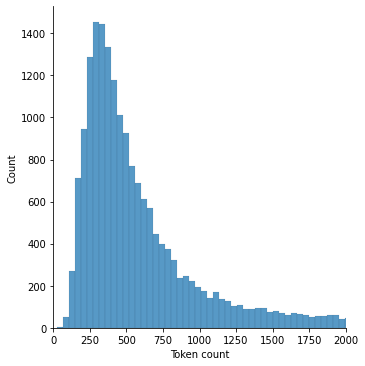

In [85]:
sns.displot(token_lens)
plt.xlim([0, 2000]);
plt.xlabel('Token count');


In [86]:
encoded_data_train = tokenizer.batch_encode_plus(
    data[data.data_type=='train'].feature.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt')


encoded_data_val = tokenizer.batch_encode_plus(
    data[data.data_type=='Val'].feature.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt')

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data[data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type=='Val'].label.values)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


INPUT AND ATTENTION FORMAT


In [87]:
b=(data["feature"][200])
print(b)
a=tokenizer.tokenize(data["feature"][200])
print(a)
print(len(a))
print(a[:512])


साउदी अरबको जेद्दामा मनाइयो ल्होछारजेद्दा मौलिक धर्म संस्कृति परम्परालाई जगेर्ना निरन्तर उत्थान सम्बर्द्धन एवं प्रबर्द्धन साउदी अरबको जेद्धा आसपासमा तामाङ श्रमिकहरूले बृहत रूपमा सोनाम ल्होछार मनाएका ज्या ल्हो चरा बर्गको वर्ष आगमनलाई हर्षोउल्लासका मनाइयो नेपाल तामाङ घेदुङ प्रवास शाखा साउदी अरबका अध्यक्ष विगेन्द्रसिंह वाइवाको सभापतित्वमा सम्पन्न उक्त कार्यक्रमलाई घेदुङका महासचिव नवराज घिसिङले संचालन महावाणीज्य दूतावासका कार्यवाहक महावाणीज्यदूत रेवती रमण पौडेलको प्रमुख आतिथ्यता कार्यक्रममा अतिथिहरू वाणीज्यदूत मनहरी दंगाल श्रम सहचारी भोजराज घिमिरे आदिबासी जनजाति महासंघ साउदी अरबका केन्द्रिय उपाध्यक्ष बालकुमार राई आदिबासी जनजाति महासंघ क्षेत्रीय समन्वय समिति जेद्धाका अध्यक्ष ङिमा साङगे शेर्पा लगायतको उपस्थिति कार्यक्रममा गैरआवासीय नेपाली संघ साउदी अरबका उपाध्यक्ष ध्रुब रिजाल तमु धी जेद्धाका अध्यक्ष वुद्धीलाल गुरूङ नेपाली युवा क्लब जेद्धाका अध्यक्ष कृष्ण भट्टराई आवासीय नेपाली संघ क्षेत्रीय समिति जेद्धाका अध्यक्ष भिम गुरूङ समाजसेवी कलाकार धनबहादुर गुरुङ बरिष्ठ समाजसेवी बेद कुमार गुरुङ समाजसेव

In [88]:
x=tokenizer.convert_tokens_to_ids(tokenizer.tokenize(b))
print(x)
print(len(x))

[898, 11208, 111194, 27425, 851, 11549, 18351, 12512, 85705, 15552, 77225, 12347, 889, 16380, 34231, 13874, 13718, 893, 20429, 17110, 13718, 108021, 19885, 77285, 15552, 77225, 889, 78530, 11714, 13671, 24589, 109900, 12213, 45753, 61533, 65986, 15801, 872, 61809, 11549, 22949, 11208, 884, 46354, 55874, 11549, 855, 11845, 69002, 21202, 898, 45753, 41082, 60254, 20429, 51799, 21850, 885, 18321, 41082, 60254, 20429, 51799, 898, 11208, 111194, 27425, 851, 11549, 18351, 12512, 85705, 43228, 11208, 852, 13432, 42035, 110427, 880, 49362, 11208, 81489, 896, 53606, 13671, 37392, 13665, 887, 111207, 108775, 54321, 898, 73354, 49362, 893, 20429, 17110, 13718, 108021, 19885, 889, 16380, 50877, 872, 17279, 893, 20429, 17110, 13718, 870, 31277, 887, 11549, 65536, 12512, 24332, 852, 103067, 11453, 26377, 85465, 76979, 13718, 111194, 101668, 13432, 15399, 889, 16380, 34231, 13874, 13718, 29953, 880, 49362, 11208, 81489, 868, 82813, 14070, 81489, 885, 18321, 102116, 896, 11208, 45319, 898, 11208, 1111

In [89]:
encoded_data = tokenizer.encode_plus(
    text=b, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt')

input_ids = encoded_data['input_ids']
attn_mask = encoded_data['attention_mask']
print(input_ids)
print(attn_mask)


tensor([[   101,    898,  11208, 111194,  27425,    851,  11549,  18351,  12512,
          85705,  15552,  77225,  12347,    889,  16380,  34231,  13874,  13718,
            893,  20429,  17110,  13718, 108021,  19885,  77285,  15552,  77225,
            889,  78530,  11714,  13671,  24589, 109900,  12213,  45753,  61533,
          65986,  15801,    872,  61809,  11549,  22949,  11208,    884,  46354,
          55874,  11549,    855,  11845,  69002,  21202,    898,  45753,  41082,
          60254,  20429,  51799,  21850,    885,  18321,  41082,  60254,  20429,
          51799,    898,  11208, 111194,  27425,    851,  11549,  18351,  12512,
          85705,  43228,  11208,    852,  13432,  42035, 110427,    880,  49362,
          11208,  81489,    896,  53606,  13671,  37392,  13665,    887, 111207,
         108775,  54321,    898,  73354,  49362,    893,  20429,  17110,  13718,
         108021,  19885,    889,  16380,  50877,    872,  17279,    893,  20429,
          17110,  13718,    

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [90]:
encoded_data_train

{'input_ids': tensor([[   101,    898,  14070,  ...,      0,      0,      0],
        [   101,  18263, 102116,  ...,      0,      0,      0],
        [   101,  29953,    886,  ...,      0,      0,      0],
        ...,
        [   101,    898,  60439,  ...,      0,      0,      0],
        [   101,    884,  69897,  ...,  12512,    877,    102],
        [   101,    867,  78660,  ...,      0,      0,      0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [91]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [92]:
len(dataset_train),len(dataset_val)

(13993, 5997)

In [93]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [94]:
batch_size = 10

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [95]:

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [96]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [97]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [98]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [100]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [101]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    FILE="model.pth"   
    torch.save(model.state_dict(),FILE)
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 0.774211784247309
Validation loss: 0.4464052262250334
F1 Score (Weighted): 0.8661487805126504



Epoch 2
Training loss: 0.35088468113781085
Validation loss: 0.39290056812693364
F1 Score (Weighted): 0.8985044111137481



Epoch 3
Training loss: 0.23258523184706323
Validation loss: 0.3379022820526734
F1 Score (Weighted): 0.9266329570401924



Epoch 4
Training loss: 0.16706847259741542
Validation loss: 0.34821979524742347
F1 Score (Weighted): 0.9289447025419796



Epoch 5
Training loss: 0.12254796852415893
Validation loss: 0.36754188633931334
F1 Score (Weighted): 0.9275351564958325



In [102]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [103]:
model.load_state_dict(torch.load('/content/model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [104]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [105]:
accuracy_per_class(predictions, true_vals)

Class: diaspora
Accuracy: 547/600

Class: economy
Accuracy: 540/600

Class: entertainment
Accuracy: 544/600

Class: health
Accuracy: 552/600

Class: international
Accuracy: 565/597

Class: opinion
Accuracy: 537/600

Class: politics
Accuracy: 577/600

Class: society
Accuracy: 531/600

Class: sports
Accuracy: 592/600

Class: technology
Accuracy: 578/600



In [106]:
from sklearn.metrics import classification_report

In [107]:
from sklearn.metrics import classification_report
print(classification_report(predictions,true_vals))

ValueError: ignored

In [ ]:
labels_flat, preds_flat